In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [2]:
#Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from scipy.stats import chi2_contingency
from scipy.stats import spearmanr
%matplotlib inline
import itertools
import os
import calendar
from datetime import datetime
from scipy import stats
from scipy.special import inv_boxcox
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split as split

Helper Functions

In [3]:
def get_numerical_and_categorical_col(df):
    numerical_col = []
    cat_col = []
    for col in df.columns:
        if str(df[col].dtype).startswith(('int','float')):
            numerical_col.append(col)
        elif str(df[col].dtype) == 'category':
            cat_col.append(col)
    return numerical_col, cat_col

In [4]:
def change_to_categorical(data, max_cat=10):
  df = data.copy()
  for col in df.columns:
        if df[col].dtype == object or str(df[col].dtype).startswith(('int','float')):
            count = len(df[col].unique())
            if count <= max_cat:
                df[col] = df[col].astype('category')
  return df

In [5]:
# Helper method for printing percentage on count plot
def print_percent_count_plot(value_counts, ax):
    total = sum(value_counts)
    for idx, count in value_counts.iteritems():            
      percent_val = (count*100)/total
      add_to_idx = 0
      if min(value_counts.index) > 0:
        add_to_idx = 1
      plt.text(idx - add_to_idx-.1,count/2,str(round(percent_val))+'%')

In [6]:

def get_count_plot(x, df, ax, y=None, value_counts = None, print_percent = False):
  if value_counts is None:
    counts = df[x].value_counts().sort_index()
  else:
    counts = df[value_counts]
  #counts.plot.bar()
  #sns bars are just more colorful :P
  if y is None:
    sns.countplot(x, data=df, ax=ax)
  else:
    sns.barplot(x, y, data=df, ax=ax)
  if print_percent:
    print_percent_count_plot(counts, ax)

In [7]:
def get_count_plot_for_categorical(df, n_cols = 2, y='cnt', list_cat=None, value_counts=None, print_percent=False):
  if list_cat is None:
    num_col, cat_col = get_numerical_and_categorical_col(df)
  else:
    cat_col = list_cat
  f, axs, n_rows = get_fig_and_axis_for_subplots(len(cat_col), n_cols)
  for i, col in enumerate(cat_col):
    ax = plt.subplot(n_rows, n_cols, i+1)
    get_count_plot(col, df, ax, y, value_counts, print_percent)

In [8]:
def get_target_dist_with_categorical(df, n_cols = 2, y='cnt', list_cat=None, plot_type = 'box'):
  if list_cat is None:
    num_col, cat_col = get_numerical_and_categorical_col(df)
  else:
    cat_col = list_cat
  f, axs, n_rows = get_fig_and_axis_for_subplots(len(cat_col), n_cols)
  for i, col in enumerate(cat_col):
    ax = plt.subplot(n_rows, n_cols, i+1)
    if plot_type == 'box':
      sns.boxplot(x=col, data=df,y=y,orient="v",ax=ax)
    else:
      sns.violinplot(col, data=df,y=y,orient="v",ax=ax)

In [9]:
def get_fig_and_axis_for_subplots(total, n_cols = 2):
  rows = total/ n_cols
  n_rows = int(np.ceil(rows))
  f, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 3))
  plt.subplots_adjust(top = 0.99, bottom=0.01, hspace=.25, wspace=0.4)
  if rows* n_cols < n_rows * n_cols:
    diff = n_rows - rows
    for i in range(n_cols-int(np.ceil(diff))):
      if n_rows == 1:
        f.delaxes(axs[n_cols-1-i])
      else:
        f.delaxes(axs[n_rows-1, n_cols-1-i])     
  return f, axs, n_rows

In [10]:
def get_plot_for_numerical(df, n_cols = 2, plot_type='probability',list_col=None, hist=True, kde=True):
  if list_col is None:
      num_col, cat_col = get_numerical_and_categorical_col(df)
  else:
      num_col = list_col
  f, axs, n_rows = get_fig_and_axis_for_subplots(len(num_col), n_cols)
  for i, col in enumerate(num_col):
    ax = plt.subplot(n_rows, n_cols, i+1)
    if plot_type == 'probability':
      sns.distplot(df[col], hist=hist, kde=hist, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})
    elif plot_type == 'box':
      sns.boxplot(data=df,y=col,orient="v",ax=ax)
    else:
      sns.violinplot(data=df,y=col,orient="v",ax=ax)

In [11]:
# visualize correlation matrix
def visualize_corr_matrix(data):
    numerical_col, cat_col = get_numerical_and_categorical_col(data)
    df = data[numerical_col]
    corr = df.corr()# plot the heatmap
    #generating masks for upper triangle so that values are not repeated
    mask_ut=np.triu(np.ones(corr.shape)).astype(np.bool)
    sns.heatmap(corr, mask=mask_ut, xticklabels=corr.columns, yticklabels=corr.columns, annot=True, cmap=sns.diverging_palette(220, 20, as_cmap=True))

In [12]:
def remove_outliers_for_variable_by_quantiles(data, col, q1=.25, q2=.75):
  df = data.copy()
  median = df[col].median()
  q25, q75 = df[col].quantile([q1,q2])
  iqr = q75-q25
  upper_wh = q75 +1.5*iqr
  lower_wh = q25 - 1.5*iqr
  whiskers = int(np.floor(lower_wh)), int(np.ceil(upper_wh))
  df.drop(df[~df[col].between(whiskers[0], whiskers[1]) & (~np.isnan(df[col]))].index, inplace=True)
  return df

In [13]:
def remove_outliers_for_variable_by_std(data, col):
  df = data.copy()
  df = df[np.abs(df[col]-df[col].mean())<=(3*df[col].std())] 
  return df

In [14]:
#loop for chi square values
def calculate_chi_square_values(df, alpha=.05):
    chi2_dict = {}
    numerical_col, cat_col  = get_numerical_and_categorical_col(df)
    for i in cat_col:
        for j in cat_col:
            if i!=j and (j+' '+i) not in chi2_dict.keys():
                chi2, p, dof, ex = chi2_contingency(pd.crosstab(df[i], df[j]))
                chi2_dict[i+' '+j] = 'Independent? '+ str(p>alpha)
    return chi2_dict

In [15]:
def rmsle(y, y_,convertExp=True):
    
    if convertExp:
        y = inv_boxcox(y, fitted_lambda),
        y_ = inv_boxcox(y_, fitted_lambda)
    log1 = np.nan_to_num(np.array([np.log(v + 1) for v in y]))
    log2 = np.nan_to_num(np.array([np.log(v + 1) for v in y_]))
    calc = (log1 - log2) ** 2
    return np.sqrt(np.mean(calc))

In [16]:
def plot_prediction(test, test_pred, train, train_pred, convert_to_original_form = False):
    if convert_to_original_form:
        test = inv_boxcox(test, fitted_lambda),
        test_pred = inv_boxcox(test_pred, fitted_lambda)
        train = inv_boxcox(train, fitted_lambda),
        train_pred = inv_boxcox(train_pred, fitted_lambda)
    f, ax = plt.subplots(1,2, figsize=(10, 5))
    ax1 = plt.subplot(1,2,1)
    sns.distplot(test, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax = ax1)
    sns.distplot(test_pred, hist=True, kde=True, 
             color = 'red', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4}, ax = ax1)
    ax1.set_title("Actual vs Predicted (Test)")
    
    ax2 = plt.subplot(1,2,2)
    sns.distplot(train, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4}, ax = ax2)
    sns.distplot(train_pred, hist=True, kde=True, 
             color = 'red', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4}, ax = ax2)
    ax2.set_title("Actual vs Predicted (Train)")

Basic Info About Data

In [17]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/bike-sharing-demand/sampleSubmission.csv
/kaggle/input/bike-sharing-demand/train.csv
/kaggle/input/bike-sharing-demand/test.csv


In [18]:

df_hour = pd.read_csv("/kaggle/input/bike-sharing-demand/train.csv")
df_test = pd.read_csv("/kaggle/input/bike-sharing-demand/test.csv")

In [19]:
df_hour.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


Feature Engineering

In [20]:
df_hour["dteday"] = df_hour.datetime.apply(lambda x : x.split()[0])
df_hour["yr"] = df_hour.datetime.apply(lambda x : x.split()[0][:4])
df_hour['yr'] = df_hour.yr.map({'2011': 0, '2012':1})
df_hour["hr"] = df_hour.datetime.apply(lambda x : x.split()[1].split(":")[0])
df_hour["weekday"] = df_hour.dteday.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
df_hour.weekday = df_hour.weekday.map({'Saturday':6, 'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5})
df_hour["mnth"] = df_hour.dteday.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
df_hour.mnth = df_hour.mnth.map({'January':0, 'February':1, 'March':2, 'April':3, 'May':4, 'June':5, 'July':6,
       'August':7, 'September':8, 'October':9, 'November':10, 'December':11})
df_hour["weathersit"] = df_hour.weather
df_hour['dteday'] = pd.to_datetime(df_hour['dteday'])
del df_hour['weather']
del df_hour['datetime']

In [21]:

#performing same on test
#performing same on test
df_test["dteday"] = df_test.datetime.apply(lambda x : x.split()[0])
df_test["yr"] = df_test.datetime.apply(lambda x : x.split()[0][:4])
df_test['yr'] = df_test.yr.map({'2011': 0, '2012':1})
df_test["hr"] = df_test.datetime.apply(lambda x : x.split()[1].split(":")[0])
df_test["weekday"] = df_test.dteday.apply(lambda dateString : calendar.day_name[datetime.strptime(dateString,"%Y-%m-%d").weekday()])
df_test.weekday = df_test.weekday.map({'Saturday':6, 'Sunday':0, 'Monday':1, 'Tuesday':2, 'Wednesday':3, 'Thursday':4, 'Friday':5})
df_test["mnth"] = df_test.dteday.apply(lambda dateString : calendar.month_name[datetime.strptime(dateString,"%Y-%m-%d").month])
df_test.mnth = df_test.mnth.map({'January':0, 'February':1, 'March':2, 'April':3, 'May':4, 'June':5, 'July':6,
       'August':7, 'September':8, 'October':9, 'November':10, 'December':11})
df_test["weathersit"] = df_test.weather
df_test['dteday'] = pd.to_datetime(df_test['dteday'])
del df_test['weather']


In [22]:

df_hour['cnt'] = df_hour['count']
del df_hour['count']
df_hour.shape

(10886, 16)

In [23]:
df_hour.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   season      10886 non-null  int64         
 1   holiday     10886 non-null  int64         
 2   workingday  10886 non-null  int64         
 3   temp        10886 non-null  float64       
 4   atemp       10886 non-null  float64       
 5   humidity    10886 non-null  int64         
 6   windspeed   10886 non-null  float64       
 7   casual      10886 non-null  int64         
 8   registered  10886 non-null  int64         
 9   dteday      10886 non-null  datetime64[ns]
 10  yr          10886 non-null  int64         
 11  hr          10886 non-null  object        
 12  weekday     10886 non-null  int64         
 13  mnth        10886 non-null  int64         
 14  weathersit  10886 non-null  int64         
 15  cnt         10886 non-null  int64         
dtypes: datetime64[ns](1), 

No null values and all categorical values present as they have already been encoded

In [24]:
df_hour.columns

Index(['season', 'holiday', 'workingday', 'temp', 'atemp', 'humidity',
       'windspeed', 'casual', 'registered', 'dteday', 'yr', 'hr', 'weekday',
       'mnth', 'weathersit', 'cnt'],
      dtype='object')

In [25]:
#Creating a copy of df to preserve original df
df = df_hour.copy()

In [26]:
#Analysing which of these are categorical variables
for col in df.columns:
  print('Count of unique values for ', col, ': ', len(df[col].unique()))

Count of unique values for  season :  4
Count of unique values for  holiday :  2
Count of unique values for  workingday :  2
Count of unique values for  temp :  49
Count of unique values for  atemp :  60
Count of unique values for  humidity :  89
Count of unique values for  windspeed :  28
Count of unique values for  casual :  309
Count of unique values for  registered :  731
Count of unique values for  dteday :  456
Count of unique values for  yr :  2
Count of unique values for  hr :  24
Count of unique values for  weekday :  7
Count of unique values for  mnth :  12
Count of unique values for  weathersit :  4
Count of unique values for  cnt :  822


In [27]:
'''We know maximum categories for any categorical col is 24 (for month)
Hence we can use this to def function to convert variable to categorical type'''
df = change_to_categorical(df, max_cat=24)

In [28]:
df.dtypes

season              category
holiday             category
workingday          category
temp                 float64
atemp                float64
humidity               int64
windspeed            float64
casual                 int64
registered             int64
dteday        datetime64[ns]
yr                  category
hr                  category
weekday             category
mnth                category
weathersit          category
cnt                    int64
dtype: object

In [29]:
get_numerical_and_categorical_col(df)

(['temp', 'atemp', 'humidity', 'windspeed', 'casual', 'registered', 'cnt'],
 ['season',
  'holiday',
  'workingday',
  'yr',
  'hr',
  'weekday',
  'mnth',
  'weathersit'])

Analysing type of data
Checking for count type of variables in dataframe

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


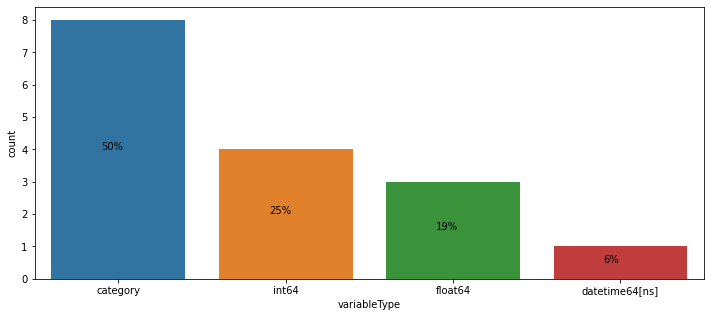

In [30]:
dataTypeDf = (df.dtypes.astype(str).value_counts()).reset_index().rename(columns={"index":"variableType",0:"count"})
fig,ax = plt.subplots()
fig.set_size_inches(12,5)
get_count_plot('variableType',dataTypeDf, ax, 'count', value_counts='count', print_percent=True)

So we have 50% of data as categorical data

Exploratory Data Analysis

In [32]:
#Descriptive stats for numerical and categorical values
df[get_numerical_and_categorical_col(df)[0]].describe()

,temp,atemp,humidity,windspeed,casual,registered,cnt
count,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [33]:
df[get_numerical_and_categorical_col(df)[1]].describe(include='all')

,season,holiday,workingday,yr,hr,weekday,mnth,weathersit
count,10886,10886,10886,10886,10886,10886,10886,10886
unique,4,2,2,2,24,7,12,4
top,4,0,1,1,12,6,4,1
freq,2734,10575,7412,5464,456,1584,912,7192


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

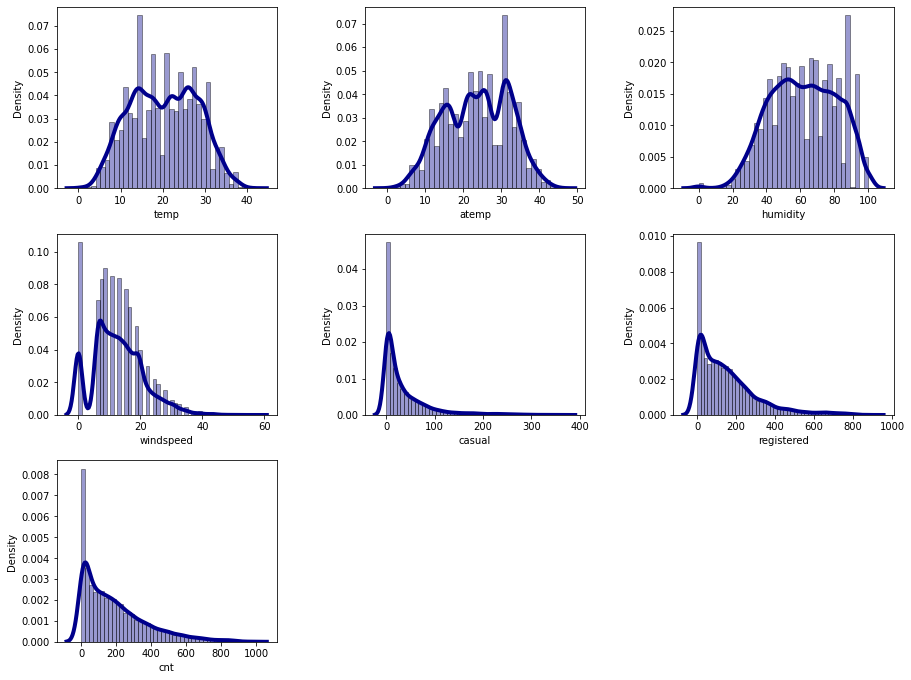

In [34]:
get_plot_for_numerical(df,3)

Cnt, casual and registered have log normal distribution, can be converted to near normal taking log of these variables.
Also, did you see uncanny similarity between these 3 variables?
Either we're too lucky to get such a data set or is it too good to be true?
Let's dig deeper!!

In [ ]:
#Visualizing correlation Matrix
plt.figure(figsize=(7,5))
visualize_corr_matrix(df)

<h1>The Analysis</h1>
<br><br>Let's set a threshold, if two input variables have correlation greater than +- 0.4, they're good candidates for adding Multicollinearity hence one of them should be dropped.
Multicollinearity is dangerous as model won't be able to accurately which of the two variables is predicting it. Thus coefficients/ weights won't be assigned properly
atemp and temp have .99 correlation
<br><br>Nothing surprising as they're essentially same values in different units. Let's drop one to them.
windspeed has very low predicting power, should be dropped too. casual seems to have g Registered and casual are highly correlated with each other, hence can drop one of these.
<br><br>But wait for discussion part 2 on this, coming right after!

<h1>Analysis Part 2</h1><br> Hmm registered variable is predicting count by .97!
This dataset is almost like winning a lottery in data science!
No now we're not just sniffing but sure there is something fishy about registered and casual!
<br>
Embrace yourself!
We've found... (Drum rolls in the background :P) Leakage Variables in our data set!

<h5>Leakage Variables:</h5><br> Variables that expose information about the target variable
When data contains a certain feature that already predicts the target has already occurred.
<br>
In our problem registered and nonregistered variables are the leakage variables because for any given row total count of these two variables tells us that this was the number of cyclists for the row hence it is directly predicting the target.<br>
<a href="https://link.medium.com/Rk1IJWxeK9">More on this here</a>

In [38]:

'''Let's start creating a list which contains all the variables to be deleted.
We can delete them once we're done with our exploratory analysis'''
cols_to_remove = ['registered','casual','windspeed']
#besides atemp should be deleted immediately for obvious reasons!
del df['atemp']
del df_test['atemp']

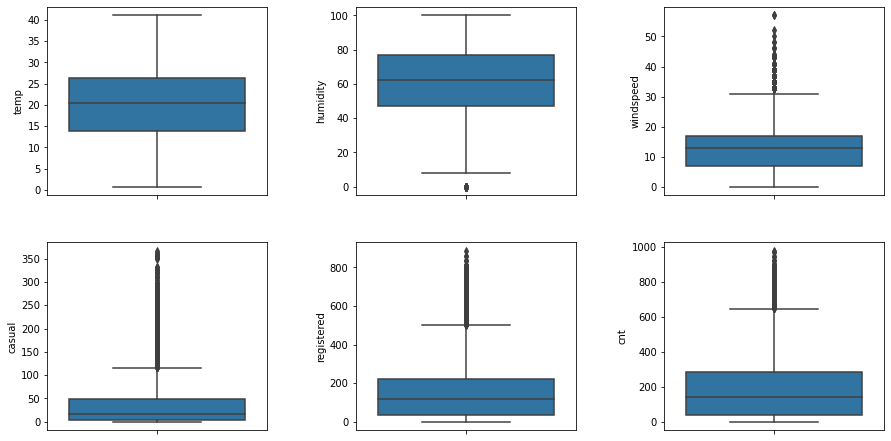

In [39]:
#Outlier Analysis
get_plot_for_numerical(df, 3, plot_type='box')

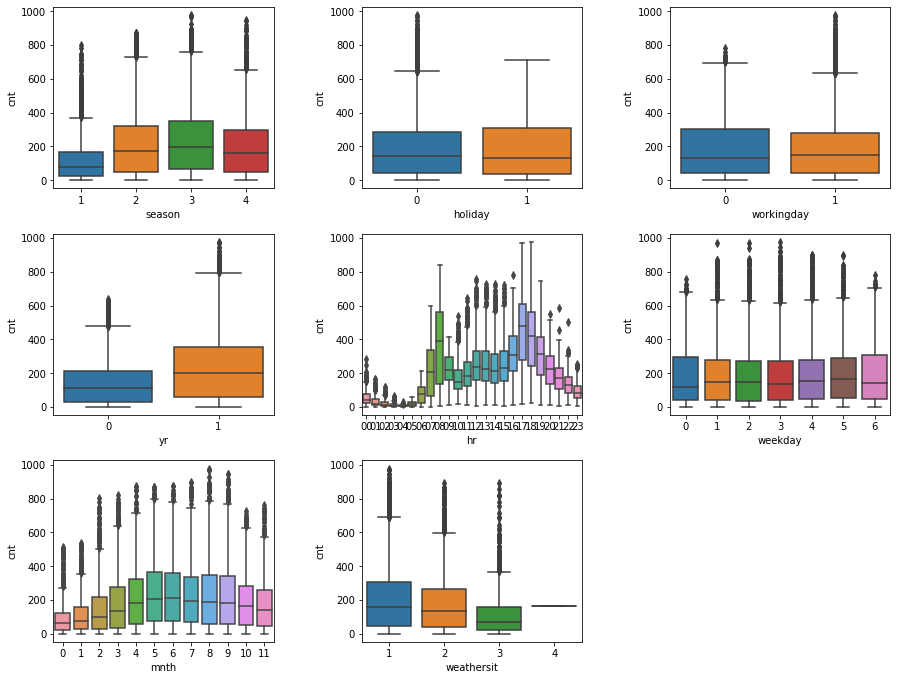

In [40]:
get_target_dist_with_categorical(df,n_cols=3)

/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/opt/conda/lib/python3.7/site-packages/seaborn

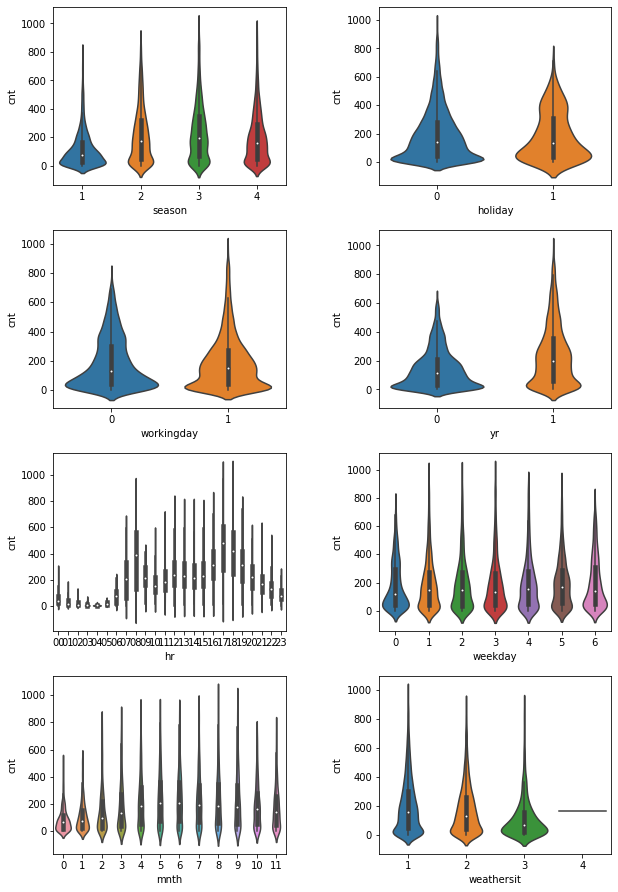

In [41]:
get_target_dist_with_categorical(df, n_cols=2, plot_type='violin')

It’s pretty evident outliers have been contributed the most by season 3. Also average numbers are highest in this season.<br>
Working day or not, mean bikers count is almost the same telling us that biking is not just being used for leisure but for daily activities too.
Same is supported by the fact there is high rise in number of bikers from 7 to 9 AM and 5 to 7 and gradually decreasing on both sides, suggesting these as school or office commute hours.
Outliers in the evening time and on holidays or working or the seasons least favourable for bike rides may suggest an event in the city!
<br>
Month, hr and season seem to be good predictors
<br>
Distribution across all parameters is almost log normal, right skewed.

In [42]:
#Let's perform categorical test chi2 to decide which categorical columns to delete
chi2_dict = calculate_chi_square_values(df)
chi2_dict

{'season holiday': 'Independent? False',
 'season workingday': 'Independent? True',
 'season yr': 'Independent? True',
 'season hr': 'Independent? True',
 'season weekday': 'Independent? True',
 'season mnth': 'Independent? False',
 'season weathersit': 'Independent? False',
 'holiday workingday': 'Independent? False',
 'holiday yr': 'Independent? True',
 'holiday hr': 'Independent? True',
 'holiday weekday': 'Independent? False',
 'holiday mnth': 'Independent? False',
 'holiday weathersit': 'Independent? True',
 'workingday yr': 'Independent? True',
 'workingday hr': 'Independent? True',
 'workingday weekday': 'Independent? False',
 'workingday mnth': 'Independent? False',
 'workingday weathersit': 'Independent? False',
 'yr hr': 'Independent? True',
 'yr weekday': 'Independent? True',
 'yr mnth': 'Independent? True',
 'yr weathersit': 'Independent? False',
 'hr weekday': 'Independent? True',
 'hr mnth': 'Independent? True',
 'hr weathersit': 'Independent? False',
 'weekday mnth': 'In

From the visual analysis, month, hr, season seems to be a good predictor.<br>
Out of these 3, month and season describe the most!<br>
Hence we'll remove all other categorical values dependent on hr<br>
Weathersit is dependent on all
holiday, weekday, workingday, month, season all dependent!

In [44]:
cols_to_remove.append('season')
cols_to_remove.append('holiday')
cols_to_remove.append('weekday')
cols_to_remove.append('weathersit')

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.4980392156862745, 0.054901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.17254901960784313, 0.6274509803921569, 0.17254901960784313)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/opt/conda/lib/python3.7/site-pa

<AxesSubplot:xlabel='hr', ylabel='cnt'>

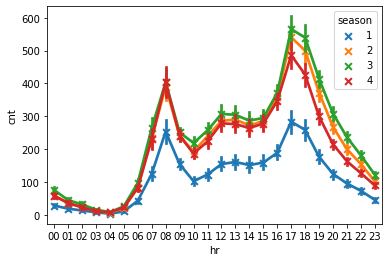

In [45]:
sns.pointplot(x='hr',y='cnt',data=df, hue='season', markers = 'x')

/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.12156862745098039, 0.4666666666666667, 0.7058823529411765)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((1.0, 0.4980392156862745, 0.054901960784313725)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/opt/conda/lib/python3.7/site-packages/seaborn/categorical.py:1784: UserWarning: You passed a edgecolor/edgecolors ((0.17254901960784313, 0.6274509803921569, 0.17254901960784313)) for an unfilled marker ('x').  Matplotlib is ignoring the edgecolor in favor of the facecolor.  This behavior may change in the future.
  zorder=z)
/opt/conda/lib/python3.7/site-pa

<AxesSubplot:xlabel='hr', ylabel='cnt'>

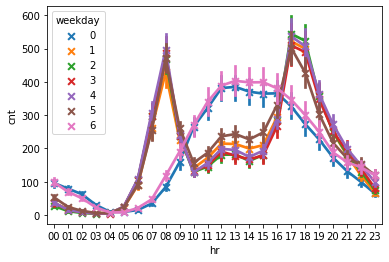

In [46]:
sns.pointplot(x='hr',y='cnt',data=df, hue='weekday', markers = 'x')

In [47]:

#to visualize similar plot for type of user, we would need to use melt
#what melt would do, take each hour and generate rows for value variables. Next we'll use this to find mean for each hour and for each type of users
hr_users_type = pd.melt(df[["hr","casual","registered"]], id_vars=['hr'], value_vars=['casual', 'registered']).sort_values(by='hr')
hr_users_type.head()

,hr,variable,value
0,00,casual,3
5014,00,casual,10
949,00,casual,0
14869,00,registered,80
5038,00,casual,19


In [48]:
hr_users_type_mean = pd.DataFrame(hr_users_type.groupby(["hr","variable"],sort=True)["value"].mean()).reset_index()
hr_users_type_mean.head()

,hr,variable,value
0,00,casual,10.312088
1,00,registered,44.826374
2,01,casual,6.513216
3,01,registered,27.345815
4,02,casual,4.819196


<AxesSubplot:xlabel='hr', ylabel='value'>

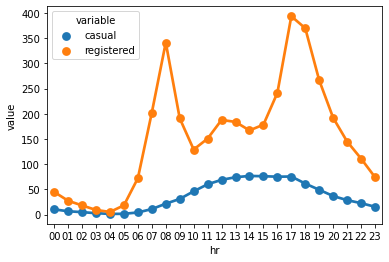

In [49]:

sns.pointplot(x=hr_users_type_mean["hr"], y=hr_users_type_mean["value"],hue=hr_users_type_mean["variable"],hue_order=["casual","registered"], data=hr_users_type_mean, join=True)

In [50]:
#We done with visually exploring data, let's just see how many variables we decided to drop
#Also we should be dropping dteday too
cols_to_remove.append('dteday')
cols_to_remove

['registered',
 'casual',
 'windspeed',
 'season',
 'holiday',
 'weekday',
 'weathersit',
 'dteday']

In [51]:
df.columns

Index(['season', 'holiday', 'workingday', 'temp', 'humidity', 'windspeed',
       'casual', 'registered', 'dteday', 'yr', 'hr', 'weekday', 'mnth',
       'weathersit', 'cnt'],
      dtype='object')

In [52]:
#deleting outliers from all numerical variables
for col in get_numerical_and_categorical_col(df)[0]:
 df = remove_outliers_for_variable_by_std(df, col)

<h1>Using Random Forest for feature importance</h1>
Using Random Forest to get feature importance values and we'll be comparing it with our list of columns to remove
<br>... Moment of truth... Hang on

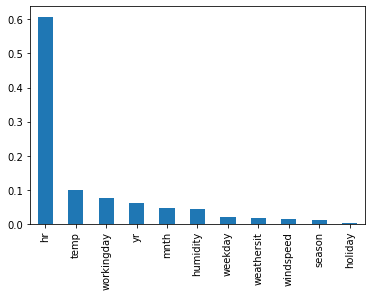

hr            0.607868
temp          0.098320
workingday    0.077106
yr            0.059989
mnth          0.046770
humidity      0.043228
weekday       0.020729
weathersit    0.018351
windspeed     0.013436
season        0.012065
holiday       0.002138
dtype: float64
Comparing with our columns
['registered', 'casual', 'windspeed', 'season', 'holiday', 'weekday', 'weathersit', 'dteday']


In [53]:
from sklearn.ensemble import RandomForestRegressor
np.random.seed(42)
# drop target columns
df_original = df.copy()
drop_cols=['cnt', 'dteday','registered','casual']
X = df.drop(drop_cols, axis = 1) # X = independent columns (potential predictors)
y = df['cnt'] # y = target column (what we want to predict)
# instantiate RandomForestClassifier
rf_model = RandomForestRegressor()
rf_model.fit(X,y)
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
# determine 20 most important features
df_imp_feat = feat_importances.nlargest(20)
df_imp_feat.plot(kind='bar')
plt.show()
print(df_imp_feat)
print('Comparing with our columns')
print(cols_to_remove)

Phew!! So far so good!
<br>One last important step is left...
<br>Yes, you guessed it right! Let's go and clean the dataset by dropping the identified variables!
<br>Woah, it was fun getting our hands dirty here!

In [55]:
df_cleaned = df.copy()
df_cleaned.drop(cols_to_remove, axis=1, inplace=True)
df_test.drop(cols_to_remove, axis=1, inplace=True, errors='ignore')
df_cleaned.head()

,workingday,temp,humidity,yr,hr,mnth,cnt
0,0,9.84,81,0,00,0,16
1,0,9.02,80,0,01,0,40
2,0,9.02,80,0,02,0,32
3,0,9.84,75,0,03,0,13
4,0,9.84,75,0,04,0,1


<h3>Feature Scaling¶</h3>
Do we need to? Let's find out..!!

In [57]:
df_cleaned.describe()

,temp,humidity,cnt
count,10212.000000,10212.000000,10212.000000
mean,19.886526,62.785351,165.837446
std,7.754532,18.900830,145.386936
min,0.820000,8.000000,1.000000
25%,13.940000,48.000000,38.000000
50%,19.680000,63.000000,133.000000
75%,26.240000,78.000000,257.000000
max,41.000000,100.000000,617.000000


# # Yes!! Feature scaling is definitely required because we've observed there's linear relationship
<br>Hence to try on linear models, we need features to be scaled.
<br>There wouldn't have been a need if features would have been in similar ranges but guess God has different plans for us! :(
<h1>Log transform for target variable</h1>
Since it's a lognormal distribution, it's important to transform to near gaussian for linear regression models

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

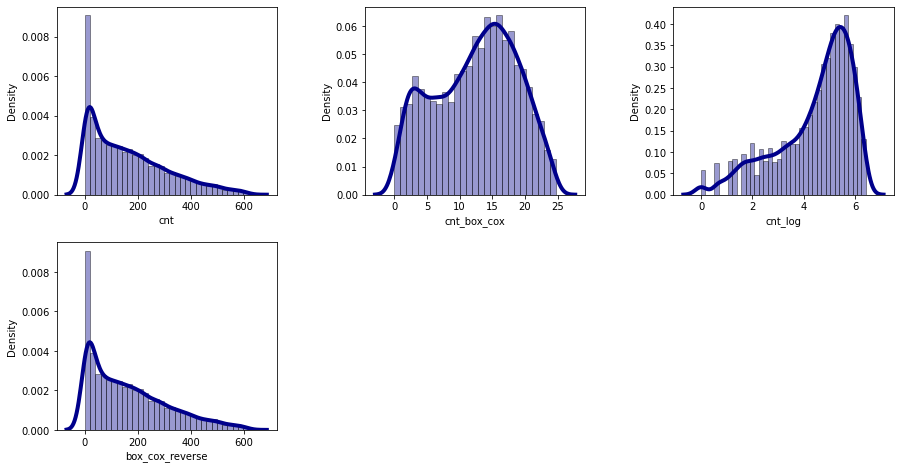

In [59]:
# transform training data & save lambda value 
fitted_data, fitted_lambda = stats.boxcox(df_cleaned.cnt)
df_cleaned['cnt_box_cox'] = fitted_data
df_cleaned['cnt_log'] = np.log(df_cleaned.cnt)
#to be used for last step
df_cleaned['box_cox_reverse'] = inv_boxcox(fitted_data, fitted_lambda)

get_plot_for_numerical(df_cleaned, 3, list_col=['cnt','cnt_box_cox','cnt_log','box_cox_reverse'])

We can see box cox has produced better distribution than simply taking log, due to hyper parameter

In [60]:
df_cleaned.drop(['cnt','cnt_log','box_cox_reverse'], axis=1, inplace=True)
df_cleaned.rename(columns={'cnt_box_cox':'count_transformed'}, inplace=True)

Moving on to feature Scaling!
<br>We're spoilt by choices here too!
<br>
# The big question!! Normalize or Standardize??
Normalization when distribution does not follow a Gaussian distribution. This can be useful in algorithms that do not assume any distribution of the data like K-Nearest Neighbors and Neural Networks.
<br>Standardization, helpful where the data follows a Gaussian distribution. However, this does not have to be necessarily true. Also, unlike normalization, standardization does not have a bounding range. So, even if you have outliers in your data, they will not be affected by standardization.
<br>Woah! Ironical!! Normalization is actually for non normal distribution
<br>Our distribution is not perfectly normal and it still does contain some outlier. Let's go with standardization.

In [61]:

sc = StandardScaler()

# Hold on!! First Split, then Normalize!!!
Here's why!
<br>You first need to split the data into training and test set (validation set could be useful too).
<br>Don't forget that testing data points represent real-world data. Feature normalization (or data standardization) of the explanatory (or predictor) variables is a technique used to center and normalise the data by subtracting the mean and dividing by the variance. If you take the mean and variance of the whole dataset you'll be introducing future information into the training explanatory variables (i.e. the mean and variance).
<br>Therefore, you should perform feature normalisation over the training data. Then perform normalisation on testing instances as well, but this time using the mean and variance of training explanatory variables. In this way, we can test and evaluate whether our model can generalize well to new, unseen data points.

In [62]:
target = 'count_transformed'
X = df_cleaned.drop(target, axis=1)
y = df_cleaned[target]
seed=23
X_train, X_test, y_train, y_test = split(X, y, test_size=.3, random_state=seed)

In [63]:

X_train = sc.fit_transform(X_train)
X_test = sc.fit_transform(X_test)

# Fitting the Models
Starting with the basics!

# Linear Regression Model

In [64]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error as mse
from sklearn import metrics

# Initialize logistic regression model
lr = LinearRegression()

# Train the model
lr.fit(X_train,y = y_train)

# Make predictions
y_pred = lr.predict(X_test)

y_pred_train = lr.predict(X_train)

print('RMSLE for test: ',rmsle(y_test, y_pred, True))
print('RMSLE for train: ',rmsle(y_train, y_pred_train, True))

RMSLE for test:  0.9985727395602558
RMSLE for train:  1.0178349170195686


In [65]:
coeff_df = pd.DataFrame(lr.coef_, X.columns, columns=['Coefficient'])  
coeff_df

,Coefficient
workingday,-0.032395
temp,1.680904
humidity,-1.432221
yr,0.859433
hr,2.898253
mnth,0.972177


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

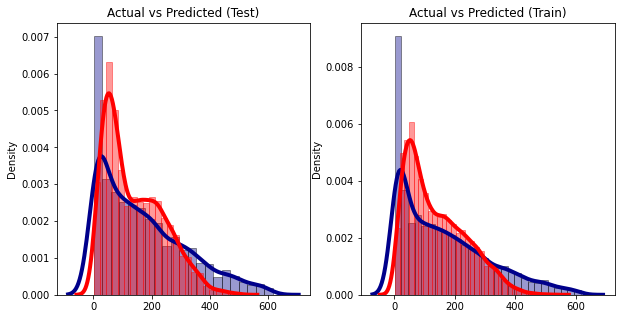

In [66]:
plot_prediction(y_test, y_pred, y_train, y_pred_train, True)

# Regularizing Linear Regression

In [68]:
ridge = Ridge()
ridge_param = {'max_iter':[3000], 'alpha':[.1,.03,.3,1,3,10, 30, 100,300]}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
grid_ridge = GridSearchCV(ridge,
                           ridge_param,
                           scoring = rmsle_scorer,
                           cv = 10)
grid_ridge.fit(X_train, y_train)
y_pred_ridge = grid_ridge.predict(X_test)
y_pred_ridge_train = grid_ridge.predict(X_train)
print('Grid Ridge Best Params: ', grid_ridge.best_params_)
print('RMSLE for test: ',rmsle(y_test, y_pred_ridge, True))
print('RMSLE for train: ',rmsle(y_train, y_pred_ridge_train, True))

Grid Ridge Best Params:  {'alpha': 0.03, 'max_iter': 3000}
RMSLE for test:  0.9985729962538497
RMSLE for train:  1.0178354304286803


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

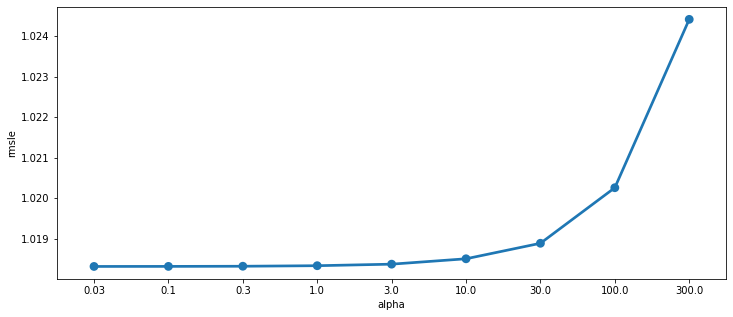

In [69]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(grid_ridge.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

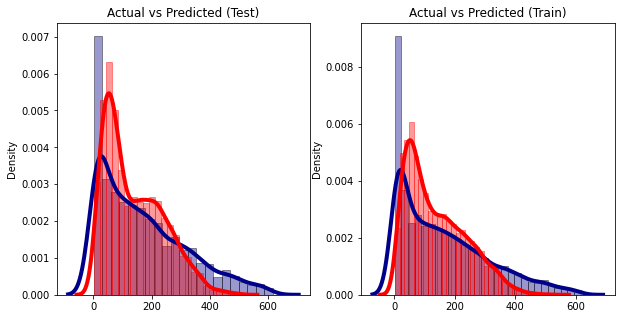

In [70]:
plot_prediction(y_test, y_pred_ridge, y_train, y_pred_ridge_train, True)

# Lasso Regression

In [71]:
lasso = Lasso()
alpha = 1/np.array([.1,.03,.3,1,3,10, 30, 100,300,1000])
lasso_param = {'max_iter':[3000], 'alpha':alpha}
rmsle_scorer = metrics.make_scorer(rmsle, greater_is_better=False)
random_lasso = RandomizedSearchCV(lasso,
                           lasso_param,
                           scoring = rmsle_scorer,
                           cv = 10)
random_lasso.fit(X_train, y_train)
y_pred_lasso = random_lasso.predict(X_test)
y_pred_lasso_train = random_lasso.predict(X_train)
print('Random Lasso Best Params: ', random_lasso.best_params_)
print('RMSLE for test: ',rmsle(y_test, y_pred_lasso, True))
print('RMSLE for train: ',rmsle(y_train, y_pred_lasso_train, True))

Random Lasso Best Params:  {'max_iter': 3000, 'alpha': 0.001}
RMSLE for test:  0.9985825557822441
RMSLE for train:  1.017881896254066


<AxesSubplot:xlabel='alpha', ylabel='rmsle'>

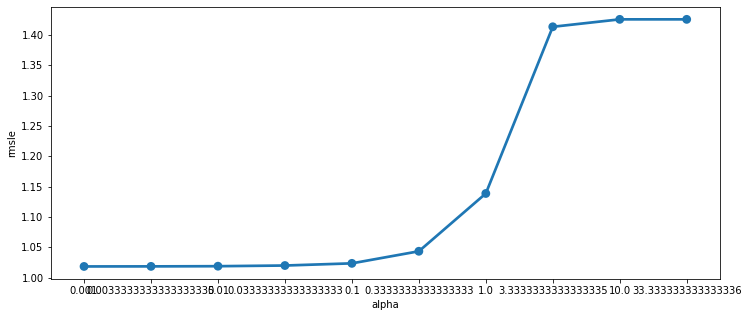

In [72]:
fig,ax= plt.subplots()
fig.set_size_inches(12,5)
df = pd.DataFrame(random_lasso.cv_results_)
df["alpha"] = df["params"].apply(lambda x:x["alpha"])
df["rmsle"] = df["mean_test_score"].apply(lambda x:-x)
sns.pointplot(data=df,x="alpha",y="rmsle",ax=ax)

/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

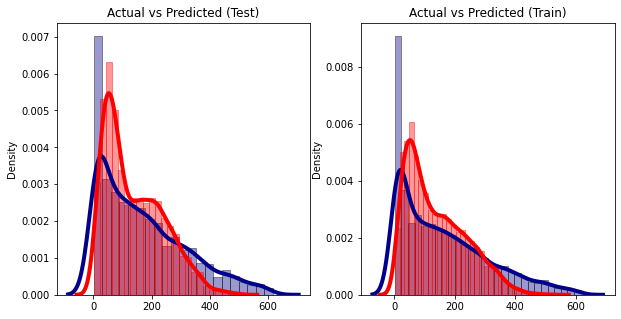

In [73]:
plot_prediction(y_test, y_pred_lasso, y_train, y_pred_lasso_train, True)

In [74]:
from sklearn.tree import DecisionTreeRegressor as dt
dt_m = dt(random_state=0)
dt_m.fit(X_train,y_train)
y_pred_dt=dt_m.predict(X_test)
y_pred_dt_train=dt_m.predict(X_train)
print('RMSLE for test: ',rmsle(y_test, y_pred_dt, True))
print('RMSLE for train: ',rmsle(y_train, y_pred_dt_train, True))

RMSLE for test:  0.4762426563579512
RMSLE for train:  0.05591386220370898


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

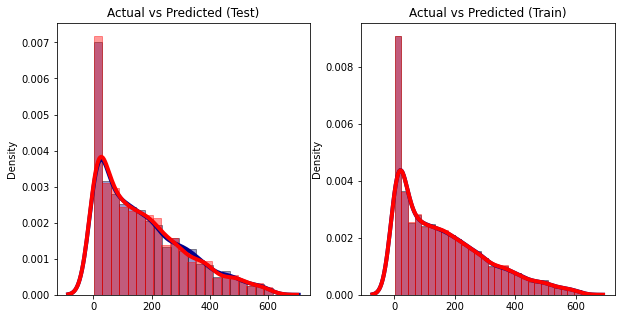

In [76]:
plot_prediction(y_test, y_pred_dt, y_train, y_pred_dt_train, True)

RMSLE value for train and the plot above suggests it has overfit.

# Random Forest Regressor

In [77]:

from sklearn.ensemble import RandomForestRegressor as rfr
rf = rfr(n_estimators=100)
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
y_pred_rf_train = rf.predict(X_train)
print('RMSLE for test: ',rmsle(y_test, y_pred_rf, True))
print('RMSLE for train: ',rmsle(y_train, y_pred_rf_train, True))

RMSLE for test:  0.35374022283974266
RMSLE for train:  0.14736934379515668


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

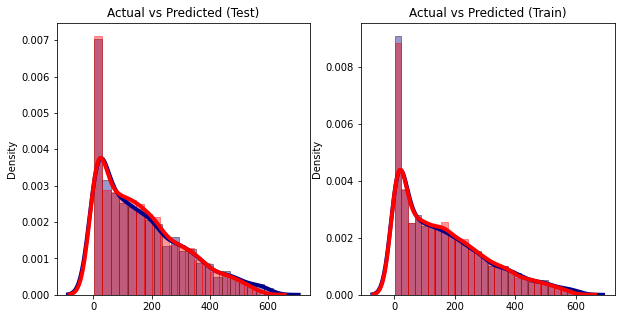

In [78]:
plot_prediction(y_test, y_pred_rf, y_train, y_pred_rf_train, True)

In [79]:
from sklearn.ensemble import GradientBoostingRegressor
gbm = GradientBoostingRegressor(n_estimators=3000,alpha=.03)
gbm.fit(X_train,y_train)
y_pred_gbm = gbm.predict(X_test)
y_pred_gbm_train = gbm.predict(X_train)
print('RMSLE for test: ',rmsle(y_test, y_pred_gbm, True))
print('RMSLE for train: ',rmsle(y_train, y_pred_gbm_train, True))

RMSLE for test:  0.34931866449177434
RMSLE for train:  0.278449029335745


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function 

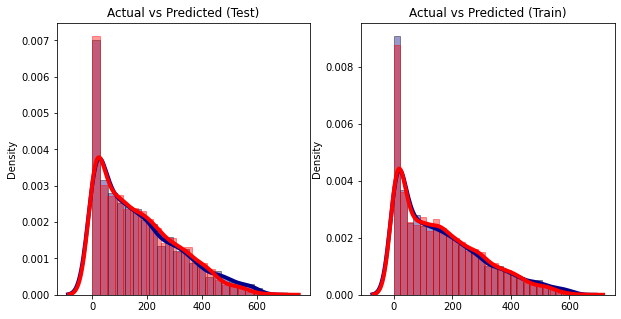

In [80]:
plot_prediction(y_test, y_pred_gbm, y_train, y_pred_gbm_train, True)

# The final Verdict!!
<br>1. Linear Regression and even the type 1 and type 2 regularizations are not pretty good at predicting.
<br>2. Decision Tree performed moderately but since there was no pruning, hence it was overfitting the data.
<br>The 2 finalists are....
<br>Random Forest and XGBoost.. well the competition was really close!
<br>Both performed equally well on test (validation data) But the tie break was the train score!!
# And the winner is... (drumrolls..) "XGBoost"
Well not because it scored better for test but because it performed relatively poorer on training set because that is what we want for model to over fit!

In [81]:
df_test = df_test.sort_values(by='datetime')
datetime_series = df_test.datetime
df_test_for_model = df_test.copy()
df_test_for_model.drop(['datetime'], inplace=True, axis=1)
X_test_ndarry = df_test_for_model.to_numpy()
final_X_test = sc.fit_transform(X_test_ndarry)
final_y_pred = inv_boxcox(gbm.predict(final_X_test), fitted_lambda)

In [82]:
final_y_pred_rf = inv_boxcox(rf.predict(final_X_test), fitted_lambda)

In [83]:
final_y_pred.shape, datetime_series.shape

((6493,), (6493,))

In [84]:
submission = pd.DataFrame({'datetime':datetime_series, 'count':np.round(final_y_pred)})

In [85]:
submission_rf = pd.DataFrame({'datetime':datetime_series, 'count':final_y_pred_rf})

In [86]:
submission.head()

,datetime,count
0,2011-01-20 00:00:00,11.0
1,2011-01-20 01:00:00,5.0
2,2011-01-20 02:00:00,3.0
3,2011-01-20 03:00:00,2.0
4,2011-01-20 04:00:00,2.0


/opt/conda/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

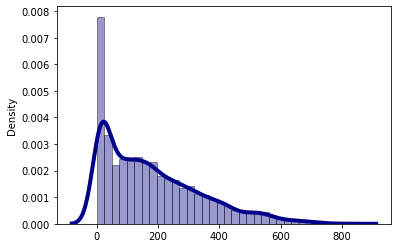

In [87]:
sns.distplot(final_y_pred, hist=True, kde=True, 
             color = 'darkblue', 
             hist_kws={'edgecolor':'black'},
             kde_kws={'linewidth': 4})

In [88]:
#Just to avoid any missing values
submission[submission['count'].isna()]

,datetime,count
722,2011-03-31 02:00:00,NaN
723,2011-03-31 03:00:00,NaN
724,2011-03-31 04:00:00,NaN


In [89]:
#let's see values around it to fill these
#intuition knn
submission.iloc[721],submission.iloc[720],submission.iloc[719]

(datetime    2011-03-31 01:00:00
 count                       0.0
 Name: 721, dtype: object,
 datetime    2011-03-31 00:00:00
 count                       0.0
 Name: 720, dtype: object,
 datetime    2011-03-30 23:00:00
 count                       3.0
 Name: 719, dtype: object)

In [90]:
#By this and also by our initial analysis, afternoon is not a preferable time to ride bike
submission.fillna(0, inplace=True)

In [91]:
submission.iloc[725],submission.iloc[726],submission.iloc[727]

(datetime    2011-03-31 05:00:00
 count                       0.0
 Name: 725, dtype: object,
 datetime    2011-03-31 06:00:00
 count                      10.0
 Name: 726, dtype: object,
 datetime    2011-03-31 07:00:00
 count                      41.0
 Name: 727, dtype: object)

In [92]:
submission.to_csv('bike_predictions_rounded.csv', index=False)
submission.to_csv('bike_predictions_random_forest.csv', index=False)